# Segmentation Practical

by Dominic Waithe (2019)  

Instructions:  
Work through the notebook cell-by-cell. Where you see TODO, this means you need to do something. Optional TODO means you should do it if you are finding things too easy and have enough time.
Many of the exercises below utilise the Skimage Python library, if in doubt, google the function names, to find out additional description.
Some of the cells also involve plotting. If you are having trouble understanding the plotting with Matplotlib, then I recommend the following text: https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html


In [1]:
#Library imports for this notebook. Please remember to run before any other cells.
%matplotlib inline
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import data, img_as_float,color, img_as_ubyte
from skimage import color, io
from skimage.feature import peak_local_max, canny
from skimage.transform import hough_circle,hough_circle_peaks,hough_line, hough_line_peaks
from skimage.draw import circle_perimeter
from skimage.filters import try_all_threshold, threshold_otsu
from skimage.morphology import watershed, skeletonize
from skimage.segmentation import chan_vese, felzenszwalb, slic, quickshift, watershed,mark_boundaries
from matplotlib import cm
import numpy as np


### Simple global thresholding methods
First we import an image. This is a multi-channel image with each channel representing discrete image data.
Here we preview a number of skimage thresholding strategies.


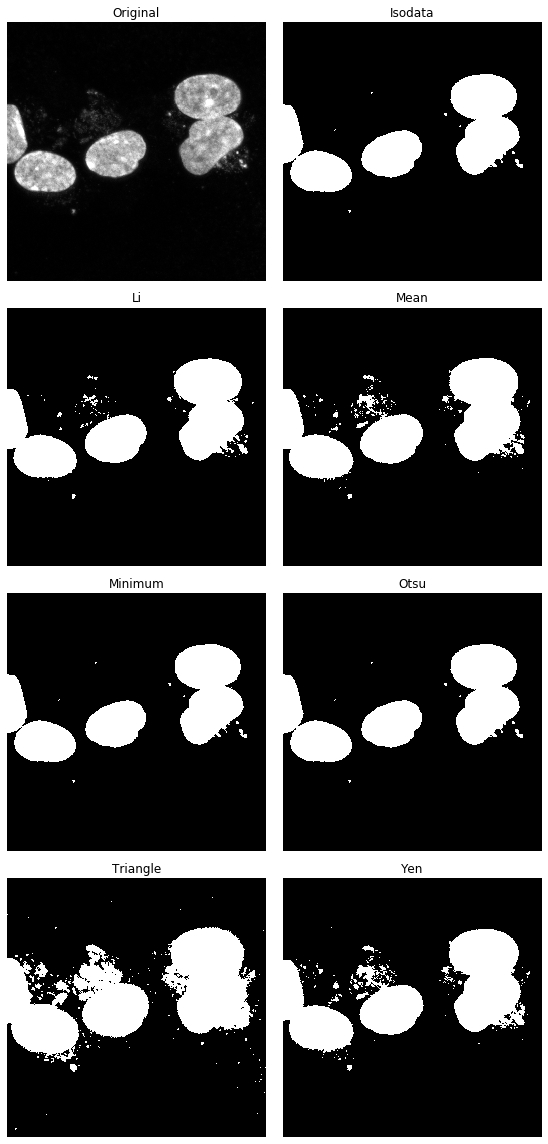

In [2]:
#Import image.
img = io.imread('images/MAX_BRCA1 C20 SCBT 50 and TBK1 A6 SCBT 100 ivt 4.tif')
#Convert image to float.
img = img_as_float(img)
#Here we index  individual channels for convenience.
img_ch0 = img[:,:,0]
img_ch1 = img[:,:,1]
img_ch2 = img[:,:,2]

#You saw this function yesterday. 
fig, ax = try_all_threshold(img_ch0, figsize=(8, 16), verbose=False)
plt.show()
#TODO, try thresholding the other channels. Does what you see make sense? 
#Would you threshold CH1 and CH2? which method would you recommend for each.

### Otsu segmentation and histogram visualisation
Here we are going to apply Otsu segmentation to one of our images and visualise the histogram.

Our calculated threshold value. 0.3593252889677272


Text(0.5, 1.0, 'Intensity histogram')

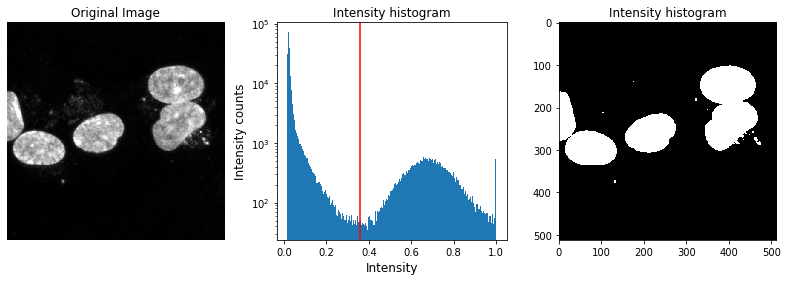

In [3]:
#Calculate threshold for the first channel of our image.
thresh = threshold_otsu(img_ch0)
#Apply the threshold to the image and generate binary image.
binary = img_ch0 > thresh
print('Our calculated threshold value.',thresh)
#Plotting
fig, ax = plt.subplots(1,3, figsize=(14, 4))


ax[0].imshow(img_ch0, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)
ax[1].hist(img_ch0.reshape(-1),bins=256)#Generate histogram.
ax[1].set_yscale("log")
ax[1].axvline(thresh, color='r')
ax[1].set_title("Intensity histogram", fontsize=12)
ax[1].set_ylabel("Intensity counts", fontsize=12)
ax[1].set_xlabel("Intensity", fontsize=12)
ax[2].imshow(binary, cmap="gray")
ax[2].set_title("Intensity histogram", fontsize=12)


#The line represents the otsu calculated threshold.

In [4]:
#TODO: From your knowledge of image acquisition, what do you notice about the distribution in the histogram which suggests the image is not optimum? 
#Ask one of the demonstrators to confirm your findings.

### Watershed algorithm
Here we are applying watershed to our image, using the distance transform representation.
Remember from the lecture that this helps us separate objects by size and intensity.

Text(0.5, 1.0, 'Labelled cells')

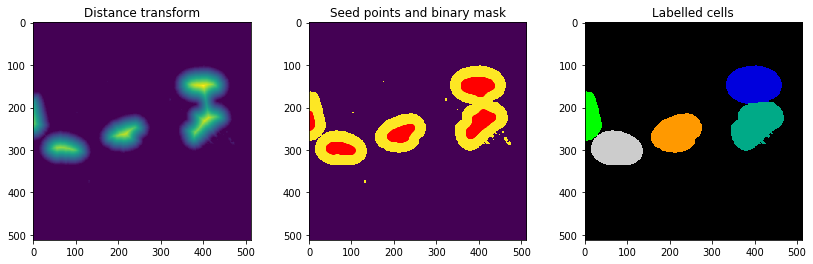

In [5]:
# Now we want to separate the cells in the image.
# Apply a distance transform to the image.
distance = ndi.distance_transform_edt(binary)#We visualise this below.

#There are different ways of setting your seed points for the watershed. This is one way:
local_maxi = np.copy(distance) #We make a copy of our image so as not to destroy the original.
local_maxi = local_maxi>(np.max(local_maxi)*0.7) #We take a threshold based on the size of the objects. The middle 30% remains as a seed for each region.


coordinates = np.where(local_maxi)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=binary)#Now we run the watershed algorithm and connect the cells to each seed point.

fig, ax = plt.subplots(1,3, figsize=(14, 4))
ax[0].imshow(distance)
ax[0].set_title("Distance transform", fontsize=12)
ax[1].plot(coordinates[1],coordinates[0],'ro')
ax[1].set_title("Seed points and binary mask", fontsize=12)
ax[1].imshow(binary)
ax[2].imshow(labels,cmap=plt.cm.nipy_spectral)#The different colours represent the different cells.
ax[2].set_title("Labelled cells", fontsize=12)

### Maxima finding
In this cell we focus on the second channel, and retrieve the foci (I.e. punctuate fluorescence).

Text(0.5, 1.0, 'Pruned Maxima')

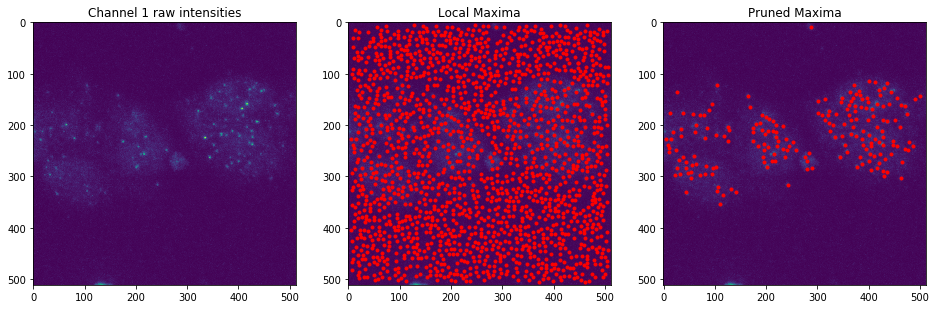

In [6]:

image_max = ndi.maximum_filter(img_ch1, size=5, mode='constant')
# Comparison between image_max and img_ch1 to find the coordinates of local maxima
coordinates_raw = peak_local_max(img_ch1, min_distance=5)
THR = np.mean(img_ch1)+(np.std(img_ch1)*3.)
coordinates = coordinates_raw[img_ch1[coordinates_raw[:,0],coordinates_raw[:,1]]>THR,:]

fig, ax = plt.subplots(1,3, figsize=(16, 8))
ax[0].imshow(img_ch1)
ax[0].set_title("Channel 1 raw intensities", fontsize=12)
ax[1].imshow(img_ch1)
ax[1].plot(coordinates_raw[:, 1], coordinates_raw[:, 0], 'r.')
ax[1].set_title("Local Maxima", fontsize=12)
ax[2].imshow(img_ch1)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].set_title("Pruned Maxima", fontsize=12)

In [7]:
#TODO: This will take sometime and is the biggest exercise in this practical.
#We want to to measure the number of foci in each cell, and also plot the intensities of the nuclear stain and that of the foci.  
# 1) You will need to identify each individual cell in your segmentation.  Use the output of the watershed algorithm (labels) as a starting point.
# A good way to do this is with the region props algorithm:
# Find it here https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
# 2) Measure in img_ch0 the intensity of each cell.
# 3) Measure in img_ch1 the intensity at each of the points found using the find maxima function in each cell.
#TIP: Find which maxima coordinates have a certain pixel value when compared to labelled cell region image (labels).
# 4) Plot the information as a scatter plot, comparing the average intensity of the maxima for each cell CH1 versus the average DAPI signal CH0 for each cell.
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html


In [8]:
#OPTIONAL TODO
#The above is a very basic maxima finding algorithm. A more advanced variant is the Fiji/ImageJ maxima.
#The following is a Python implementation of the same algorithm.
#https://github.com/dwaithe/generalMacros/blob/master/maximaFinding/find%20Maxima.ipynb
#Try this algorithm on the same image file and compare the results.

## Other Algorithms

### Chan Vese Level set algorithm
The below segmentation example is a challenging one. 

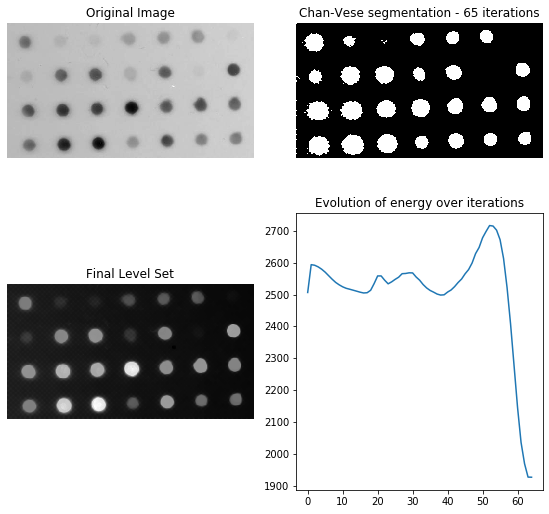

In [9]:
img = io.imread('images/Dot_Blot.jpg')
image = img_as_float(img)


# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=0.06, lambda1=1.3, lambda2=1.5, tol=1e-3, max_iter=65, dt=0.6, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [10]:
#Optional TODO:
#See if you can beat my performance with some better parameters.

### Superpixels
Here we apply SLIC to segment our cellular image. Superpixels attempt to group pixels in an image spatially and through colour (in this case intensity). Through using this technique it is possible to do a segmentation.

Text(0.5, 1.0, 'Slic segments')

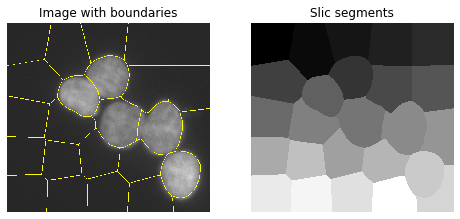

In [11]:
image = io.imread('images/HeLa_SNAP_ATRX16_BrdU_neg_UVC_30min_ATRX_green_yH2AX_red_01_03_R3D-1.tif')
img = img_as_float(image)


segments_slic = slic(img, n_segments=25, compactness=0.005, sigma=3) #Search online for help with the parameters.
mb = mark_boundaries(image*100, segments_slic) #The *100 makes the image easier to see in the figure.

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()



ax[0].imshow(mb)
ax[0].set_axis_off()
ax[0].set_title("Image with boundaries", fontsize=12)

ax[1].imshow(segments_slic, cmap="gray")
ax[1].set_axis_off()
title = "Slic segments"
ax[1].set_title(title, fontsize=12)




In [12]:
#Optional TODO: Try and do the same for 'MAX_BRCA1 C20 SCBT 50 and TBK1 A6 SCBT 100 ivt 4.tif' CH0. 
#Alter the parameters to optimise the performance.

### The Hough Circle Transform
Using the Hough Circle transform to segment Giant Plasma Membrane Vesicles (GPMVs) 

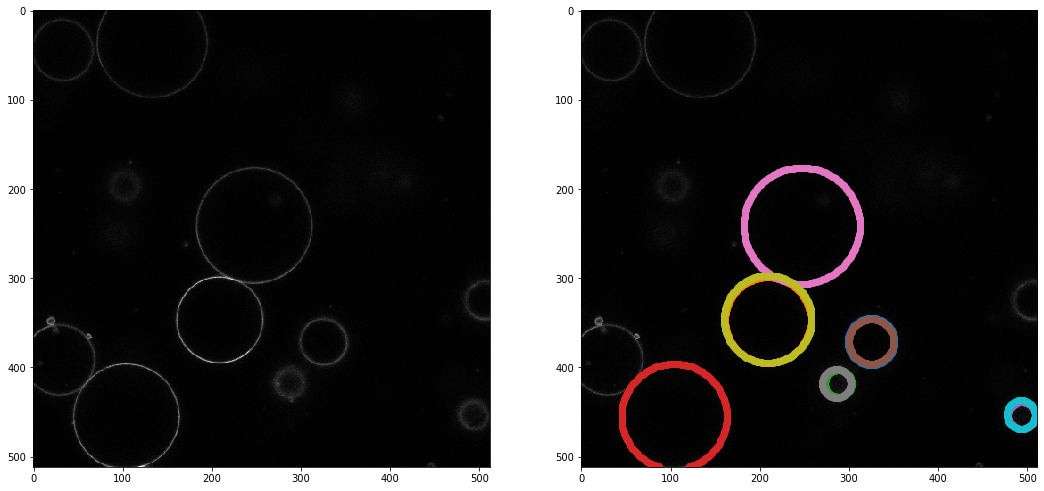

In [13]:


# Load picture, convert to grayscale and detect edges
img = io.imread('images/MAX_2phase.tif')
edges = img_as_float(img)
thresh = threshold_otsu(edges)
binary = edges > thresh

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
hough_radii = np.arange(15, 100, 1)
hough_res = hough_circle(binary, hough_radii)

# Select the most prominent circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10)


# Draw them
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 24))
image = color.gray2rgb(edges)
ax[0].imshow(image, cmap=plt.cm.gray)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    ax[1].plot(circx, circy,'o')
ax[1].imshow(image,)
plt.show()

In [14]:
#Advanced Optional TODO:
#In the above example the hough circle algorithm finds multiple circles for the same GPMV. 
#Can you devise a mechansim to only provide one circle for each GPMV.
#Can you devise a method to plot the intensity around the circle.

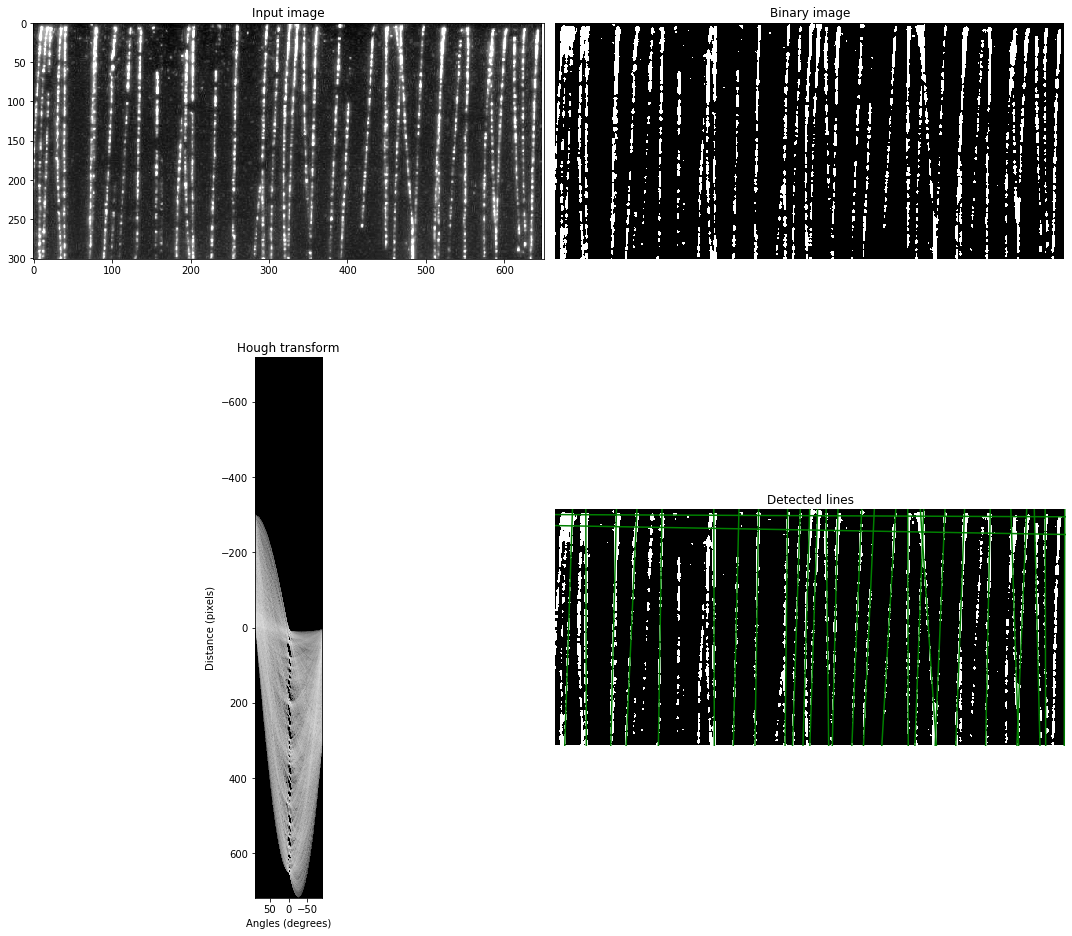

In [15]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import binary_dilation, binary_erosion
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
#Image Citation: Payne AC, Andregg M, Kemmish K, Hamalainen M, Bowell C, et al. (2013) 
#Molecular Threading: Mechanical Extraction, Stretching and Placement of DNA Molecules 
#from a Liquid-Air Interface. PLoS ONE 8(7): e69058. doi:10.1371/journal.pone.0069058


# Import image.
image = io.imread('images/DNA_stretched.tif')
edges = img_as_float(image)
thresh = threshold_otsu(edges)
binary = edges > thresh


# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 720)
h, theta, d = hough_line(binary, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax = axes.ravel()
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[1].imshow(binary, cmap=cm.gray)
ax[1].set_title('Binary image')
ax[1].set_axis_off()

ax[2].imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
ax[2].set_title('Hough transform')
ax[2].set_xlabel('Angles (degrees)')
ax[2].set_ylabel('Distance (pixels)')
ax[2].axis('image')
ax[3].imshow(binary, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    
    ax[3].plot((origin),(y0,y1), '-g')
  
ax[3].set_xlim(origin)
ax[3].set_ylim((binary.shape[0], 0))
ax[3].set_axis_off()
ax[3].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [16]:
#Advanced Optional TODO:
#Can you plot the intensities of a few of the DNA molecules along the lines.
#In the above example some of the hough lines span across the image.
#How could you refine these lines to only draw the vertical ones.